In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

# Introduction

We have a lot of input features and many labels. The goal of this Notebook is to see if we can trim the number of input features based on an array of different processing methods. For this Notebook, I will look at the following relationships to determine whether an input feature is relevant:
- correlations
- feature importances
- feature ranking with recursive feature elimination
- Principle Component Analysis (PCA)

Another interesting thing to look at would be to see what output features (labels) we can reasonably expect a machine learning model to predict. For instance, it may be that we can only predict half of the avlanche bulletin's output fields.

# Read in data

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


# Data formatting, overall distributions

I go through some of these processing steps (with more printouts) in the Notebook on data distributions, so will not go through them here.

In [3]:
# first, drop regions
labeled_data.data = labeled_data.drop_regions().data

# then, rename indices
labeled_data.data = labeled_data.data.rename_axis(['date','region'])
labeled_data.label = labeled_data.label.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
labeled_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.label.columns.values]

# replace double underscores with single underscores
labeled_data.data.columns = [col.replace('__', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('__', '_') for col in labeled_data.label.columns.values]

# convert some columns in labels to type int for averaging
labeled_data.label['CLASS_problem_amount'] = labeled_data.label['CLASS_problem_amount'].astype(int)
labeled_data.label['CLASS_danger_level'] = labeled_data.label['CLASS_danger_level'].astype(int)

for column in labeled_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        labeled_data.label[column] = labeled_data.label[column].astype(int)
        
# below, we can try to make categorical variables in the labels numeric
# first for the emergency warning column
warning_dict = {'Ikke gitt':0,
                'Naturlig utløste skred':1}

labeled_data.label['CLASS_emergency_warning'] = labeled_data.label['CLASS_emergency_warning'].replace(warning_dict)

# and now for the class problems
problem1 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_1'].values))
problem2 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_2'].values))
problem3 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_3'].values))

list_of_problems = sorted(list(np.unique(problem1 + problem2 + problem3)))
problems_dict = {'':0, 'drift-slab':1, 'glide':2, 'new-loose':3,
                 'new-slab':4, 'pwl-slab':5, 'wet-loose':6, 'wet-slab':7}

labeled_data.label['CLASS_problem_1'] = labeled_data.label['CLASS_problem_1'].replace(problems_dict)
labeled_data.label['CLASS_problem_2'] = labeled_data.label['CLASS_problem_2'].replace(problems_dict)
labeled_data.label['CLASS_problem_3'] = labeled_data.label['CLASS_problem_3'].replace(problems_dict)

# Do we have redundant features that we can collapse?

In [4]:
for column in labeled_data.data.columns:
    if 'aspect' in column:
        print(column)

problem_new-loose_aspect_N_1
problem_new-loose_aspect_NE_1
problem_new-loose_aspect_E_1
problem_new-loose_aspect_SE_1
problem_new-loose_aspect_S_1
problem_new-loose_aspect_SW_1
problem_new-loose_aspect_W_1
problem_new-loose_aspect_NW_1
problem_wet-loose_aspect_N_1
problem_wet-loose_aspect_NE_1
problem_wet-loose_aspect_E_1
problem_wet-loose_aspect_SE_1
problem_wet-loose_aspect_S_1
problem_wet-loose_aspect_SW_1
problem_wet-loose_aspect_W_1
problem_wet-loose_aspect_NW_1
problem_new-slab_aspect_N_1
problem_new-slab_aspect_NE_1
problem_new-slab_aspect_E_1
problem_new-slab_aspect_SE_1
problem_new-slab_aspect_S_1
problem_new-slab_aspect_SW_1
problem_new-slab_aspect_W_1
problem_new-slab_aspect_NW_1
problem_drift-slab_aspect_N_1
problem_drift-slab_aspect_NE_1
problem_drift-slab_aspect_E_1
problem_drift-slab_aspect_SE_1
problem_drift-slab_aspect_S_1
problem_drift-slab_aspect_SW_1
problem_drift-slab_aspect_W_1
problem_drift-slab_aspect_NW_1
problem_pwl-slab_aspect_N_1
problem_pwl-slab_aspect_NE_1

In [5]:
for column in labeled_data.label.columns:
    print(labeled_data.label[column].dtypes, '     ', column)

int64       CLASS_danger_level
int64       CLASS_emergency_warning
int64       CLASS_problem_1
int64       CLASS_problem_2
int64       CLASS_problem_3
int64       CLASS_problem_amount
object       CLASS_drift-slab_cause
int64       CLASS_drift-slab_dist
int64       CLASS_drift-slab_dsize
int64       CLASS_drift-slab_lev_fill
int64       CLASS_drift-slab_prob
int64       CLASS_drift-slab_trig
object       CLASS_glide_cause
int64       CLASS_glide_dist
int64       CLASS_glide_dsize
int64       CLASS_glide_lev_fill
int64       CLASS_glide_prob
int64       CLASS_glide_trig
object       CLASS_new-loose_cause
int64       CLASS_new-loose_dist
int64       CLASS_new-loose_dsize
int64       CLASS_new-loose_lev_fill
int64       CLASS_new-loose_prob
int64       CLASS_new-loose_trig
object       CLASS_new-slab_cause
int64       CLASS_new-slab_dist
int64       CLASS_new-slab_dsize
int64       CLASS_new-slab_lev_fill
int64       CLASS_new-slab_prob
int64       CLASS_new-slab_trig
object       CLASS_p

In [6]:
look_at = ['MULTI_drift-slab_aspect', 'MULTI_glide_aspect', 'MULTI_new-loose_aspect', 
           'MULTI_new-slab_aspect', 'MULTI_pwl-slab_aspect', 'MULTI_wet-loose_aspect', 
           'MULTI_wet-slab_aspect']

labeled_data.label.loc[:, look_at]

MULTI_drift-slab_aspect MULTI_glide_aspect  \
date       region                                              
2017-11-23 3031                  11100011           00000000   
           3034                  11100011           00000000   
2017-12-02 3003                  11111111           00000000   
           3007                  00000000           00000000   
           3009                  00000000           00000000   
...                                   ...                ...   
2021-01-12 3031                  00000000           00000000   
           3032                  00000000           00000000   
           3034                  00000000           00000000   
           3035                  00000000           00000000   
           3037                  00000000           00000000   

                  MULTI_new-loose_aspect MULTI_new-slab_aspect  \
date       region                                                
2017-11-23 3031                 00000000              00000000   
           3034                 00000000              00000000   
2017-12-02 3003                 00000000              00000000   
           3007                 00000000              00000000   
           3009                 00000000              00000000   
...                                  ...                   ...   
2021-01-12 3031                 00000000              00000000   
           3032                 00000000              00000000   
           3034                 00000000              00000000   
           3035                 00000000              00000000   
           3037                 00000000              00000000   

                  MULTI_pwl-slab_aspect MULTI_wet-loose_aspect  \
date       region                                                
2017-11-23 3031                00000000               00000000   
           3034                00000000               00000000   
2017-12-02 3003                00000000               00000000   
           3007                11111111               00000000   
           3009                11111111               00000000   
...                                 ...                    ...   
2021-01-12 3031                11111111               00000000   
           3032                11111111               00000000   
           3034                11111111               00000000   
           3035                11111111               00000000   
           3037                11111111               00000000   

                  MULTI_wet-slab_aspect  
date       region                        
2017-11-23 3031                00000000  
           3034                00000000  
2017-12-02 3003                00000000  
           3007                00000000  
           3009                00000000  
...                                 ...  
2021-01-12 3031                00000000  
           3032                00000000  
           3034                00000000  
           3035                00000000  
           3037                00000000  

[13115 rows x 7 columns]

In [7]:
for i, row in enumerate(range(labeled_data.label.loc[:, look_at].replace('00000000', np.nan).shape[0])):
    if(i==0 or i==11):
        print(labeled_data.label.loc[:, look_at].replace('00000000', np.nan).iloc[i, :].values)

['11100011' nan nan nan nan nan nan]
['11100000' nan nan nan '11111000' nan nan]


**I wonder if it isn't better to have these `cause` columns combined into one.**

**Same with the wind or `aspect` columns. Then we could groupby what the cause was to then analyze aspect or something like that. Or, like above, it only looks like each column is represented once. So I could take the only available value, and then split that into 8 new columns representing each direction, and fill with the available value. And then drop these MULTI columns.**

**Actually, same with the avalanche problems?**

# Correlation analysis

In [8]:
features_and_labels = features = pd.concat([labeled_data.data, labeled_data.label], axis=1)
features_and_labels.shape

(13115, 314)

In [9]:
# drop columns that include text, create correlations matrix
only_numeric = features_and_labels.select_dtypes(include='number')
correlations = only_numeric.corr()

# shorten the x axis to only the labels
keep_cols = [col for col in labeled_data.label if col in correlations.columns]
drop_rows = list(set(correlations.columns) - set(keep_cols))
correlations = correlations.loc[drop_rows, keep_cols]

# there are some rows with only nan values, we can drop those here
empty_rows = [item for item in correlations.index if correlations.loc[item].isna().all() == True]
correlations.drop(empty_rows, inplace = True)

In [10]:
print(correlations.shape)

(183, 55)


**That is a lot of columns, still. Another thing to try would be to drop all rows where the absolute value of the correlation is below 0.25 or 0.25, for all values. These input features probably don't need to be considered.**

In [11]:
weak_correlations = [(abs(correlations.loc[idx, :].values) < 0.25).all() for idx in correlations.index]
correlations.loc[weak_correlations, :]

,CLASS_danger_level,CLASS_emergency_warning,CLASS_problem_1,CLASS_problem_2,CLASS_problem_3,CLASS_problem_amount,CLASS_drift-slab_dist,CLASS_drift-slab_dsize,CLASS_drift-slab_lev_fill,CLASS_drift-slab_prob,...,REAL_new-loose_lev_max,REAL_new-loose_lev_min,REAL_new-slab_lev_max,REAL_new-slab_lev_min,REAL_pwl-slab_lev_max,REAL_pwl-slab_lev_min,REAL_wet-loose_lev_max,REAL_wet-loose_lev_min,REAL_wet-slab_lev_max,REAL_wet-slab_lev_min
problem_new-loose_lev_fill_2_1,0.024787,-0.011548,-0.015028,0.000360,-0.007247,0.002910,0.021098,0.005370,0.006594,0.006132,...,0.208307,0.019963,0.021861,-0.007336,-0.017469,-0.013058,-0.012688,-0.012796,-0.000378,-0.008349
problem_new-loose_lev_fill_4_1,-0.004446,-0.009574,-0.012899,-0.009626,-0.006008,-0.010156,0.002801,0.007198,0.002560,0.002164,...,0.063921,0.095178,0.022725,-0.006082,-0.017839,-0.010825,-0.011479,-0.005221,-0.009027,-0.006921
problem_wet-slab_lev_fill_2_1,0.165316,0.128492,-0.028711,0.086930,0.074779,0.074811,0.093697,0.095871,0.050728,0.060690,...,-0.014255,-0.013335,0.024796,0.018789,0.009636,0.023812,-0.036509,-0.011863,0.192163,0.209407
wind_dir_SE_0,-0.163678,-0.090673,-0.072858,-0.082714,-0.049227,-0.095405,0.011391,0.005808,0.057812,0.054498,...,-0.036883,-0.040995,-0.099093,-0.060573,0.005986,-0.013229,-0.012884,-0.021417,-0.080862,-0.069008
problem_wet-slab_cause_hoar_1,0.009280,0.015396,0.029187,0.021752,0.094086,0.042282,-0.005120,-0.009185,-0.010366,-0.010839,...,-0.002700,-0.002100,0.027279,-0.006352,-0.018633,-0.011307,-0.012901,-0.006782,0.080723,0.014138
wind_dir_E_0,-0.058502,-0.067098,-0.016152,-0.047606,-0.028178,-0.047382,-0.007230,-0.010807,-0.003661,-0.002205,...,-0.011807,-0.012932,-0.019827,0.002278,-0.018150,-0.021504,-0.009871,-0.023950,-0.055177,-0.046580
wind_dir_N_0,-0.033770,-0.042963,0.009860,-0.033326,-0.005147,-0.017025,-0.010924,-0.015650,-0.014578,-0.015316,...,0.009284,0.006415,0.005028,-0.008285,-0.000703,0.000450,-0.006493,-0.001753,-0.054071,-0.033088
wind_chg_dir_E_0,0.006003,-0.028183,-0.055363,-0.036508,-0.006128,-0.026757,0.056450,0.048752,0.049722,0.050602,...,-0.013295,-0.010343,-0.030809,-0.016772,-0.017107,-0.014638,-0.040662,-0.027472,-0.039607,-0.035602
problem_wet-loose_lev_fill_3_1,-0.037891,-0.008163,0.032096,-0.011679,-0.005123,-0.003069,-0.026886,-0.027378,-0.028652,-0.029132,...,-0.002204,-0.001715,-0.009539,-0.005186,-0.015211,-0.009231,0.044770,0.035169,-0.007698,-0.005901
problem_new-slab_lev_fill_4_1,0.010713,-0.002885,-0.008138,0.009370,-0.001811,0.006162,0.016763,0.005654,0.007000,0.006909,...,-0.000779,-0.000606,-0.003372,-0.001833,0.017752,0.003558,-0.004572,-0.003197,-0.002721,-0.002086


In [12]:
drop_weak = correlations.loc[weak_correlations, :].index.values
correlations.drop(drop_weak, inplace=True)
correlations.shape

(139, 55)

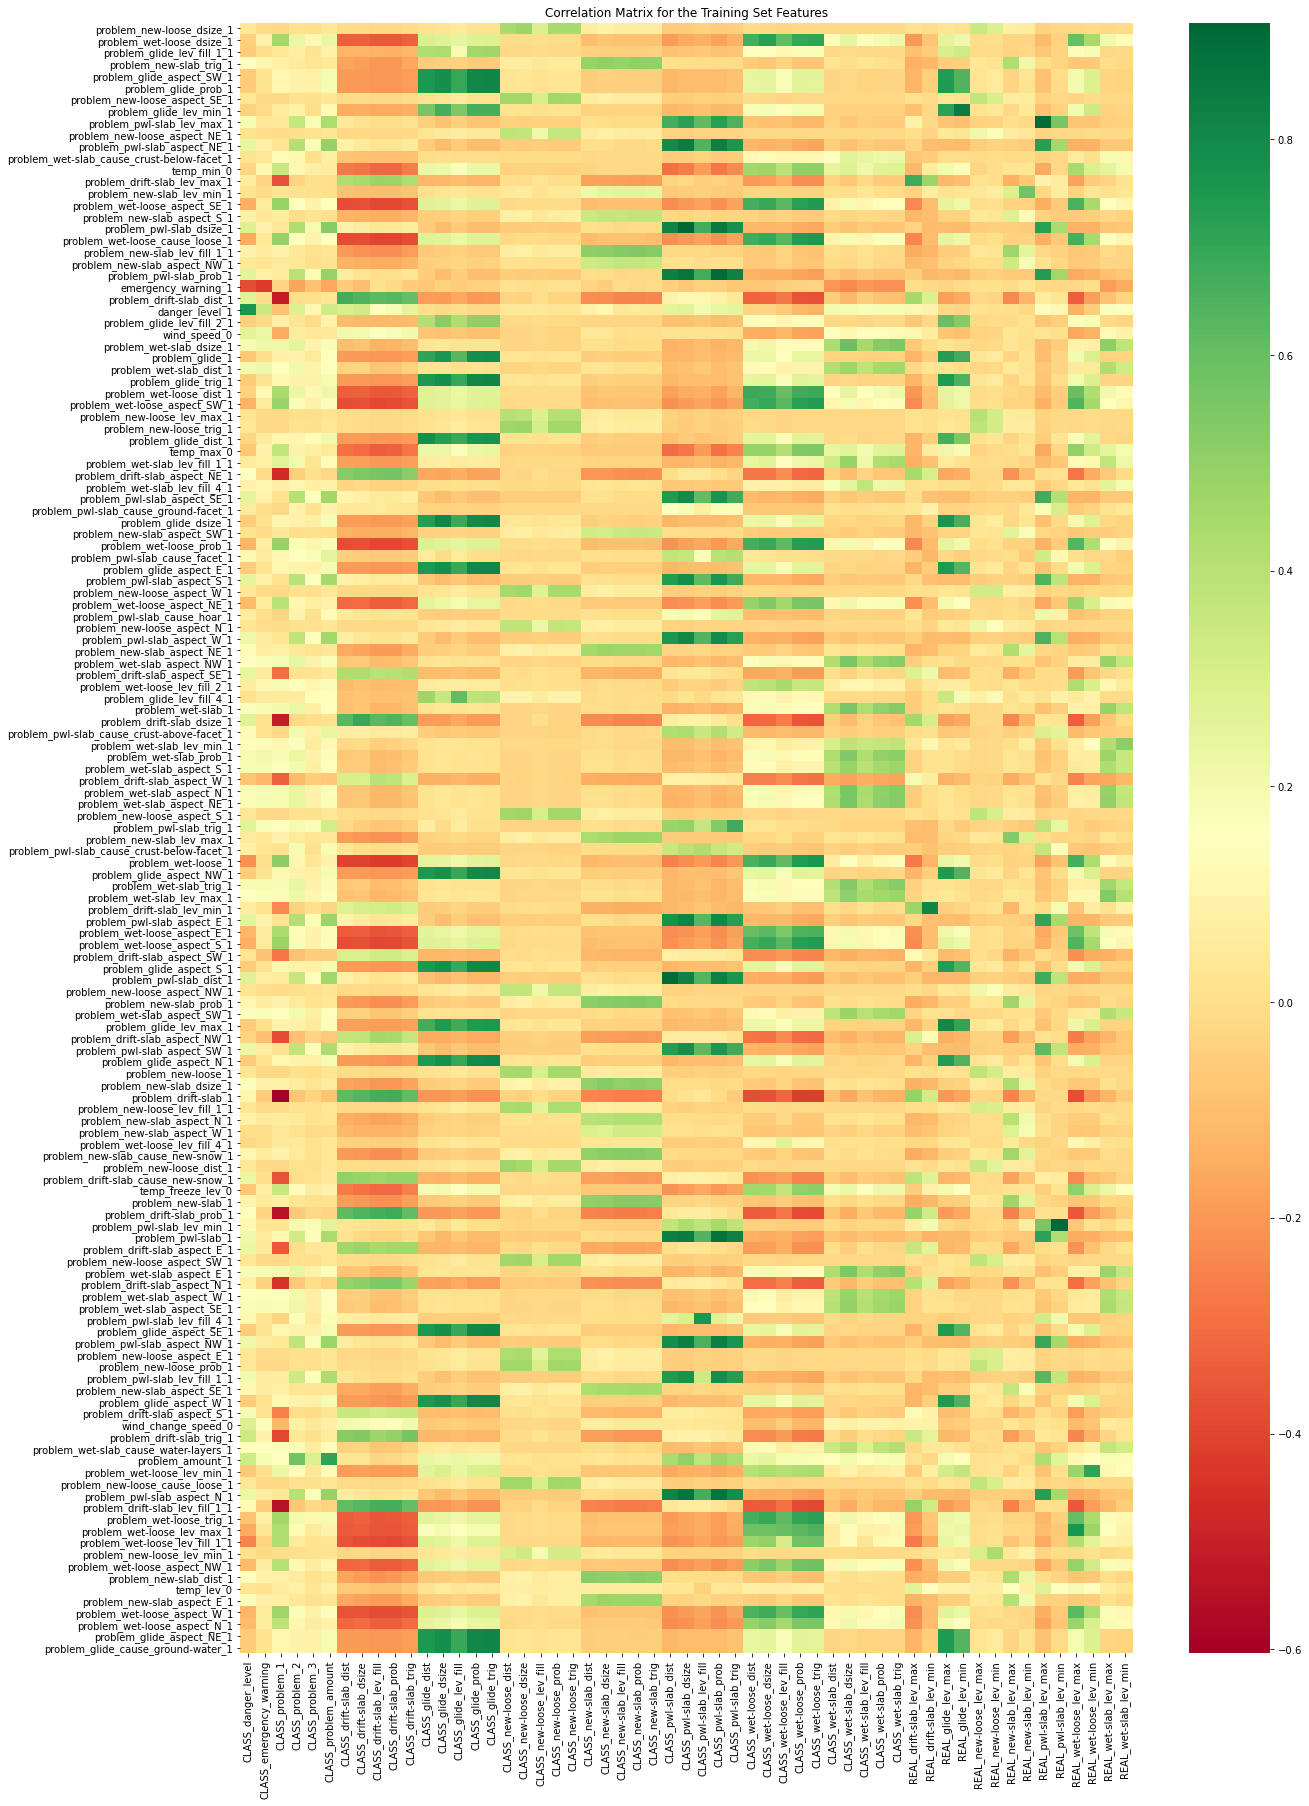

In [13]:
fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.index, cmap='RdYlGn', ax=ax)
ax.set_title('Correlation Matrix for the Training Set Features')

plt.show()

**So according to our correlation analysis, there are about 139 features out of the original 291 that are useful in predicting one or more of our labels. We can save those below and compare them with what features our other analysis find useful.**

In [14]:
keep_columns_correlations = list(correlations.index)
keep_columns_correlations

['problem_new-loose_dsize_1',
 'problem_wet-loose_dsize_1',
 'problem_glide_lev_fill_1_1',
 'problem_new-slab_trig_1',
 'problem_glide_aspect_SW_1',
 'problem_glide_prob_1',
 'problem_new-loose_aspect_SE_1',
 'problem_glide_lev_min_1',
 'problem_pwl-slab_lev_max_1',
 'problem_new-loose_aspect_NE_1',
 'problem_pwl-slab_aspect_NE_1',
 'problem_wet-slab_cause_crust-below-facet_1',
 'temp_min_0',
 'problem_drift-slab_lev_max_1',
 'problem_new-slab_lev_min_1',
 'problem_wet-loose_aspect_SE_1',
 'problem_new-slab_aspect_S_1',
 'problem_pwl-slab_dsize_1',
 'problem_wet-loose_cause_loose_1',
 'problem_new-slab_lev_fill_1_1',
 'problem_new-slab_aspect_NW_1',
 'problem_pwl-slab_prob_1',
 'emergency_warning_1',
 'problem_drift-slab_dist_1',
 'danger_level_1',
 'problem_glide_lev_fill_2_1',
 'wind_speed_0',
 'problem_wet-slab_dsize_1',
 'problem_glide_1',
 'problem_wet-slab_dist_1',
 'problem_glide_trig_1',
 'problem_wet-loose_dist_1',
 'problem_wet-loose_aspect_SW_1',
 'problem_new-loose_lev_max_

# Feature importances

Next, we can look at which features a Random Forest model thinks are important. To do this, we can use the whole dataset as a predictor for the labels.

This will look something like:
```python
X, y = labeled_data.data, labels

num_iter = 10
random = 0   #makes sure the models and grid search object give the same results every time

#instantiate models here
forest = RandomForestRegressor(random_state=random)

#define parameters dictionaries here
ensemble_params = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
             'max_depth': [1, 2, 4, 6, 8, 10, 20, 30, None],  #higher values often lead to overfitting
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
            'bootstrap': [True, False]
            }

#create our random search cv objects
forest_search = RandomizedSearchCV(estimator=forest,
                        param_distributions=ensemble_params,
                        n_iter=num_iter,         #number of parameter settings sampled
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,         #use all processors available
                        cv=5,
                        verbose=2,         #print results during tuning
                        random_state=random
)

#now fit the search objects and return them
forest_model = forest_search.fit(X, y)


print('Best RandomForest model:')
print(forest_model.best_params_, '\n')
```

```python
def plot_importances(df, labels, rf):
    """
    Input a dataframe as well as trained RandomForest model, plot feature importances.
    
    """
    columns = df.columns #all columns except the target column
    importances_rf = rf.best_estimator_.feature_importances_
    
    #take the top ten feature importances
    idx_rf = np.argsort(importances_rf)
    #idx_rf = np.argsort(importances_rf)[-10:]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    #random forest and xgboost feature importances on the same plot
    ax.set_title('Feature Importances')
    ax.barh(range(len(idx_rf)), importances_rf[idx_rf], color='tab:blue', align='center', alpha=0.5, label='RF')

    ax.set_yticks(range(len(idx_rf)))
    ax.set_yticklabels([columns[i] for i in idx_rf], fontsize=10)
    ax.set_xlabel('Relative Importance')

    ax.legend()
    plt.show()
    
# need to make sure this is using the "best" model by default
plot_importances(labeled_data.data, labels, forest_model) 

```

# Recursive Feature Elimination

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

# Principal Component Analysis
- https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
- https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

Look here for previous work that I've done as a guide: https://github.com/Jakidxav/udacity_ml_pytorch/blob/master/customer_segments_clustering/arvato_pca_clustering.ipynb

# Comments

**Summary**: 

**Recommendations**: Based on this analysis, I would recommend...